In [4]:
!pip install rioxarray rasterio pystac_client planetary_computer pystac odc

In [4]:
!pip install odc.stac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 kB 6.4 MB/s eta 0:00:00


In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
from rasterio.warp import transform_bounds
from rasterio.windows import from_bounds

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

import planetary_computer
from odc.stac import stac_load
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd


In [90]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Adding sentinel to submission data

In [14]:
ground_df = pd.read_csv("/content/drive/MyDrive/EY/Submission_template.csv")
ground_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [23]:
ground_df.shape

(1040, 3)

In [9]:
def map_satellite_data(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B04_values = []
    B06_values = []
    B08_values = []
    B03_values = []
    B11_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)

        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)

        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)

        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)

        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)

        B03_value = data.sel(x=lon, y=lat, band=5, method="nearest").values
        B03_values.append(B03_value)

        B11_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        B11_values.append(B11_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B04'] = B04_values
    df['B06'] = B06_values
    df['B08'] = B08_values
    df['B03'] = B03_values
    df['B11'] = B11_values

    return df


In [12]:
final_data = map_satellite_data('/content/drive/MyDrive/EY/S2_sample_3.tiff', '/content/drive/MyDrive/EY/Submission_template.csv')

Mapping values: 100%|██████████| 1040/1040 [00:10<00:00, 101.52it/s]


In [13]:
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan)

In [14]:
final_data['NDBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NDBI'] = final_data['NDBI'].replace([np.inf, -np.inf], np.nan)

In [15]:
final_data['NDWI'] = (final_data['B03'] - final_data['B08']) / (final_data['B03'] + final_data['B08'])
final_data['NDWI'] = final_data['NDWI'].replace([np.inf, -np.inf], np.nan)

In [33]:
def combine_two_datasets(dataset1,dataset2):
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [17]:
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

,Longitude,Latitude,UHI Index,B01,B04,B06,B08,B03,B11,NDVI,NDBI,NDWI
0,-73.971665,40.788763,NaN,794.0,502.0,2323.0,2610.0,568.0,1741.0,0.677378,-0.199724,-0.642542
1,-73.971928,40.788875,NaN,1246.0,497.0,2652.0,4268.0,661.0,2109.0,0.791396,-0.338560,-0.731791
2,-73.967080,40.789080,NaN,1020.0,1056.0,1707.0,1522.0,985.0,1658.0,0.180760,0.042767,-0.214200
3,-73.972550,40.789082,NaN,1197.0,1062.0,1918.0,1378.0,903.0,2589.0,0.129508,0.305268,-0.208242
4,-73.969697,40.787953,NaN,1006.0,917.0,2382.0,3444.0,1046.0,2001.0,0.579454,-0.265014,-0.534076


In [38]:
uhi_data.to_csv("/content/drive/MyDrive/EY/sentinel_test_df.csv", index=False)


## Adding buildings data

In [18]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
from shapely.wkt import loads
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import BallTree

In [19]:
df_heights = pd.read_csv("/content/drive/MyDrive/EY/Building_Footprints_20250313.csv")
df_heights["geometry"] = df_heights["the_geom"].apply(lambda x: loads(x) if pd.notnull(x) else None)

# Convert to GeoDataFrame (Assume it's in WGS 84)
gdf = gpd.GeoDataFrame(df_heights, geometry="geometry", crs="EPSG:4326")
gdf["centroid"] = gdf.geometry.centroid

In [20]:
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [21]:
gdf["centroid_x"] = gdf["centroid"].apply(lambda p: p.x)
gdf["centroid_y"] = gdf["centroid"].apply(lambda p: p.y)

# Apply filtering based on bounds
gdf_filtered = gdf[
    (gdf["centroid_x"] >= bounds[0]) & (gdf["centroid_x"] <= bounds[2]) &  # Longitude in range
    (gdf["centroid_y"] >= bounds[1]) & (gdf["centroid_y"] <= bounds[3])    # Latitude in range
]

In [22]:

centroids = gdf_filtered[["BIN", "centroid", "NAME", "CNSTRCT_YR", "LSTSTATYPE", "HEIGHTROOF", "GROUNDELEV", "FEAT_CODE"]]
centroids_gdf = gdf_filtered[["BIN", "centroid", "NAME", "CNSTRCT_YR", "LSTSTATYPE", "HEIGHTROOF", "GROUNDELEV", "FEAT_CODE"]]

In [23]:
submission_bld_df = pd.read_csv("/content/drive/MyDrive/EY/Submission_template.csv")
submission_bld_df['og_index'] = submission_bld_df.index

In [24]:
point_gdf = gpd.GeoDataFrame(
    submission_bld_df,
    geometry=gpd.points_from_xy(submission_bld_df["Longitude"], submission_bld_df["Latitude"]),
    crs="EPSG:4326"
)
point_gdf.head()

,Longitude,Latitude,UHI Index,og_index,geometry
0,-73.971665,40.788763,NaN,0,POINT (-73.97166 40.78876)
1,-73.971928,40.788875,NaN,1,POINT (-73.97193 40.78888)
2,-73.967080,40.789080,NaN,2,POINT (-73.96708 40.78908)
3,-73.972550,40.789082,NaN,3,POINT (-73.97255 40.78908)
4,-73.969697,40.787953,NaN,4,POINT (-73.9697 40.78795)


In [25]:
centroids["geometry"] = centroids["centroid"].apply(lambda xy: Point(xy))

centroids_gdf = gpd.GeoDataFrame(centroids, geometry="geometry", crs="EPSG:4326")

In [26]:
point_gdf["geometry"] = point_gdf.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
point_gdf = gpd.GeoDataFrame(point_gdf, geometry="geometry", crs="EPSG:4326")
print(point_gdf.iloc[:1].head())
centroids_gdf["geometry"] = centroids_gdf["centroid"].apply(lambda xy: Point(xy))
centroids_gdf = gpd.GeoDataFrame(centroids_gdf, geometry="geometry", crs="EPSG:4326")
print(centroids_gdf.head())

   Longitude   Latitude  UHI Index  og_index                    geometry
0 -73.971665  40.788763        NaN         0  POINT (-73.97166 40.78876)
        BIN                    centroid NAME  CNSTRCT_YR   LSTSTATYPE  \
18  1062896  POINT (-73.93879 40.83781)  NaN      1910.0  Constructed   
28  4029023   POINT (-73.89119 40.7527)  NaN      1950.0  Constructed   
48  2117853  POINT (-73.87295 40.80269)  NaN      1973.0  Constructed   
68  1039988  POINT (-73.96406 40.75856)  NaN      1931.0  Constructed   
86  1026714  POINT (-73.99065 40.76519)  NaN      1910.0  Constructed   

    HEIGHTROOF  GROUNDELEV  FEAT_CODE                    geometry  
18   59.722628       154.0       2100  POINT (-73.93879 40.83781)  
28   27.490000        46.0       2100   POINT (-73.89119 40.7527)  
48   10.546547        11.0       2100  POINT (-73.87295 40.80269)  
68  167.214468        52.0       2100  POINT (-73.96406 40.75856)  
86   28.570000        40.0       2100  POINT (-73.99065 40.76519)  


In [27]:
def get_nearest_neighbors(gdf1, gdf2, k_neighbors):
    src_points = np.array([(p.x, p.y) for p in gdf1.geometry])
    candidates = np.array([(p.x, p.y) for p in gdf2.geometry])

    # Create BallTree
    tree = BallTree(candidates, metric='euclidean')  # Haversine for geographic distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Convert distances from radians to meters (approximation: Earth radius ~6371km)
    # distances *= 6371000

    # Store results
    nearest_list = []
    for i, (dists, idxs) in enumerate(zip(distances, indices)):
        for rank, (dist, idx) in enumerate(zip(dists, idxs), 1):
            nearest_list.append({
                'point': gdf1.iloc[i]['geometry'],
                'og_index': gdf1.iloc[i]['og_index'],
                'market': gdf2.iloc[idx]['BIN'],
                'bld_centroid': gdf2.iloc[idx]['geometry'],
                'ground_elev': gdf2.iloc[idx]['GROUNDELEV'],
                'constr_yr': gdf2.iloc[idx]['CNSTRCT_YR'],
                'height_roof': gdf2.iloc[idx]['HEIGHTROOF'],
                'feat_code': gdf2.iloc[idx]['FEAT_CODE'],
                'distance': dist
            })

    return pd.DataFrame(nearest_list)

# Get nearest markets
nearest_markets = get_nearest_neighbors(point_gdf, centroids_gdf, k_neighbors=6)

# Display results
print(nearest_markets)

                               point  og_index   market  \
0     POINT (-73.971665 40.78876333)         0  1070900   
1     POINT (-73.971665 40.78876333)         0  1070901   
2     POINT (-73.971665 40.78876333)         0  1032304   
3     POINT (-73.971665 40.78876333)         0  1032319   
4     POINT (-73.971665 40.78876333)         0  1032303   
...                              ...       ...      ...   
6235  POINT (-73.911645 40.80440167)      1039  2003803   
6236  POINT (-73.911645 40.80440167)      1039  2004002   
6237  POINT (-73.911645 40.80440167)      1039  2003802   
6238  POINT (-73.911645 40.80440167)      1039  2003804   
6239  POINT (-73.911645 40.80440167)      1039  2129597   

                                       bld_centroid  ground_elev  constr_yr  \
0      POINT (-73.97157784508329 40.78898350866979)        108.0     1989.0   
1       POINT (-73.9712365334068 40.78883940790726)        108.0     1989.0   
2     POINT (-73.97176015549447 40.788266219558906)   

In [28]:
nearest_markets["point_str"] = nearest_markets["point"].astype(str)
mean_of_all = nearest_markets["constr_yr"].mean()
# Compute mean construction year per point group (ignoring NaNs)
mean_constr_yr = nearest_markets.groupby("point_str")["constr_yr"].transform(lambda x: x.fillna(x.mean()))

# Fill missing values
nearest_markets["constr_yr"] = nearest_markets["constr_yr"].fillna(mean_constr_yr)
nearest_markets["constr_yr"] = nearest_markets["constr_yr"].fillna(mean_of_all)
mean_ground_elev = nearest_markets["ground_elev"].mean()
nearest_markets["ground_elev"] = nearest_markets["ground_elev"].fillna(mean_ground_elev)

In [29]:
mean_constr_yr_df = nearest_markets.groupby("point_str").agg(
    mean_constr_yr=("constr_yr", "mean"),
    og_index=("og_index", "first")
).reset_index()

# Rename column for clarity
mean_constr_yr_df.rename(columns={"constr_yr": "mean_constr_yr"}, inplace=True)
mean_constr_yr_df.head()

,point_str,mean_constr_yr,og_index
0,POINT (-73.87953667 40.80615167),1998.75,182
1,POINT (-73.879635 40.80643333),1992.00,282
2,POINT (-73.87966833 40.80660333),1992.00,482
3,POINT (-73.87980333 40.80564167),1998.20,424
4,POINT (-73.88087333 40.80545833),2002.25,225


In [30]:
mean_ground_df = nearest_markets.groupby("point_str").agg(
    mean_ground_elev=("ground_elev", "mean"),
    og_index=("og_index", "first")
).reset_index()
# Rename column for clarity
mean_ground_df.head()

,point_str,mean_ground_elev,og_index
0,POINT (-73.87953667 40.80615167),15.166667,182
1,POINT (-73.879635 40.80643333),15.500000,282
2,POINT (-73.87966833 40.80660333),15.500000,482
3,POINT (-73.87980333 40.80564167),15.000000,424
4,POINT (-73.88087333 40.80545833),15.000000,225


In [31]:
grouped = nearest_markets.groupby("point_str").agg(
    mean_height_roof=("height_roof", "mean"),
    mean_distance=("distance", "mean"),
    og_index=("og_index", "first")
)

# Compute the final value for each unique point
grouped["bld_height_impact"] = grouped["mean_height_roof"] * (1 / grouped["mean_distance"])

# Reset index to make 'point' a column again
grouped = grouped.reset_index()

In [32]:
merged_train_df = pd.merge(point_gdf, mean_constr_yr_df, on="og_index", how="left")
merged_train_df.head()

,Longitude,Latitude,UHI Index,og_index,geometry,point_str,mean_constr_yr
0,-73.971665,40.788763,NaN,0,POINT (-73.97166 40.78876),POINT (-73.971665 40.78876333),1927.666667
1,-73.971928,40.788875,NaN,1,POINT (-73.97193 40.78888),POINT (-73.97192833 40.788875),1913.500000
2,-73.967080,40.789080,NaN,2,POINT (-73.96708 40.78908),POINT (-73.96708 40.78908),1923.500000
3,-73.972550,40.789082,NaN,3,POINT (-73.97255 40.78908),POINT (-73.97255 40.78908167),1906.500000
4,-73.969697,40.787953,NaN,4,POINT (-73.9697 40.78795),POINT (-73.96969667 40.78795333),1891.000000


In [33]:
merged_train_df = pd.merge(merged_train_df, mean_ground_df, on="og_index", how="left")
merged_train_df.head()

,Longitude,Latitude,UHI Index,og_index,geometry,point_str_x,mean_constr_yr,point_str_y,mean_ground_elev
0,-73.971665,40.788763,NaN,0,POINT (-73.97166 40.78876),POINT (-73.971665 40.78876333),1927.666667,POINT (-73.971665 40.78876333),106.166667
1,-73.971928,40.788875,NaN,1,POINT (-73.97193 40.78888),POINT (-73.97192833 40.788875),1913.500000,POINT (-73.97192833 40.788875),103.500000
2,-73.967080,40.789080,NaN,2,POINT (-73.96708 40.78908),POINT (-73.96708 40.78908),1923.500000,POINT (-73.96708 40.78908),116.833333
3,-73.972550,40.789082,NaN,3,POINT (-73.97255 40.78908),POINT (-73.97255 40.78908167),1906.500000,POINT (-73.97255 40.78908167),102.333333
4,-73.969697,40.787953,NaN,4,POINT (-73.9697 40.78795),POINT (-73.96969667 40.78795333),1891.000000,POINT (-73.96969667 40.78795333),112.500000


In [34]:
merged_train_df = pd.merge(merged_train_df, grouped, on="og_index", how="left")
merged_train_df.head()

,Longitude,Latitude,UHI Index,og_index,geometry,point_str_x,mean_constr_yr,point_str_y,mean_ground_elev,point_str,mean_height_roof,mean_distance,bld_height_impact
0,-73.971665,40.788763,NaN,0,POINT (-73.97166 40.78876),POINT (-73.971665 40.78876333),1927.666667,POINT (-73.971665 40.78876333),106.166667,POINT (-73.971665 40.78876333),52.781667,0.000455,115901.275183
1,-73.971928,40.788875,NaN,1,POINT (-73.97193 40.78888),POINT (-73.97192833 40.788875),1913.500000,POINT (-73.97192833 40.788875),103.500000,POINT (-73.97192833 40.788875),53.351667,0.000484,110194.891839
2,-73.967080,40.789080,NaN,2,POINT (-73.96708 40.78908),POINT (-73.96708 40.78908),1923.500000,POINT (-73.96708 40.78908),116.833333,POINT (-73.96708 40.78908),130.569716,0.000456,286631.907955
3,-73.972550,40.789082,NaN,3,POINT (-73.97255 40.78908),POINT (-73.97255 40.78908167),1906.500000,POINT (-73.97255 40.78908167),102.333333,POINT (-73.97255 40.78908167),63.755000,0.000309,206072.189714
4,-73.969697,40.787953,NaN,4,POINT (-73.9697 40.78795),POINT (-73.96969667 40.78795333),1891.000000,POINT (-73.96969667 40.78795333),112.500000,POINT (-73.96969667 40.78795333),59.019425,0.000213,277298.177450


In [36]:
buildings_df = merged_train_df.drop(columns=["og_index","geometry","point_str_x", "point_str_y", "point_str", "mean_distance"])
buildings_df.head()

,Longitude,Latitude,UHI Index,mean_constr_yr,mean_ground_elev,mean_height_roof,bld_height_impact
0,-73.971665,40.788763,NaN,1927.666667,106.166667,52.781667,115901.275183
1,-73.971928,40.788875,NaN,1913.500000,103.500000,53.351667,110194.891839
2,-73.967080,40.789080,NaN,1923.500000,116.833333,130.569716,286631.907955
3,-73.972550,40.789082,NaN,1906.500000,102.333333,63.755000,206072.189714
4,-73.969697,40.787953,NaN,1891.000000,112.500000,59.019425,277298.177450


In [37]:
buildings_df.to_csv("/content/drive/MyDrive/EY/buildings_df.csv", index=False)

## Adding LST data

In [2]:
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

In [3]:
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

In [5]:
years = range(2018, 2025)

items = []

for year in years:
    time_window = f"{year}-07-01/{year}-07-31"

    search = stac.search(
        bbox=bounds,
        datetime=time_window,
        collections=["landsat-c2-l2"],
        query={"eo:cloud_cover": {"lt": 50}, "platform": {"in": ["landsat-8"]}},
    )

    items.extend(search.item_collection())

print(f"Downloaded {len(items)} Landsat images for 2018-2024.")

Downloaded 24 Landsat images for 2018-2024.


In [6]:
resolution = 30
scale = resolution / 111320.0

data1 = stac_load(
    items,
    bands=["red", "green", "blue", "nir08"],
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds,
)

In [7]:
data2 = stac_load(
    items,
    bands=["lwir11"],
    crs="EPSG:4326",
    resolution=scale,
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds,
)

In [8]:
merged_data = xr.merge([data1, data2])

median_mosaic = merged_data.median(dim="time")

In [9]:
scale_factor = 0.00341802
add_offset = 149.0
kelvin_to_celsius = 273.15

median_mosaic["lwir11"] = median_mosaic["lwir11"] * scale_factor + add_offset - kelvin_to_celsius

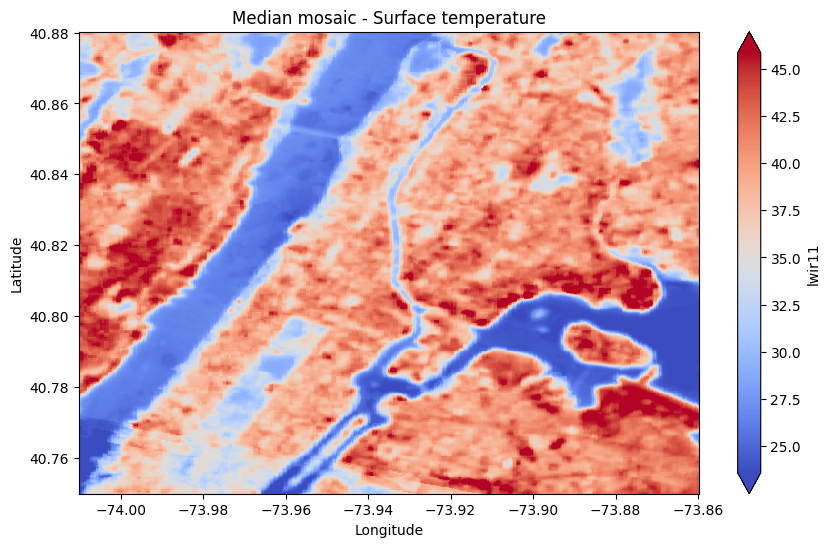

In [10]:
plt.figure(figsize=(10, 6))
median_mosaic["lwir11"].plot(cmap="coolwarm", robust=True)
plt.title("Median mosaic - Surface temperature")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [28]:
median_mosaic["lwir11"].rio.set_crs("EPSG:4326")

output_path = "/content/drive/MyDrive/EY/median_mosaic_LST.tiff"

median_mosaic["lwir11"].rio.to_raster(output_path)

print(f"Median mosaic saved to a GeoTIFF file: {output_path}")

Median mosaic saved to a GeoTIFF file: /content/drive/MyDrive/EY/median_mosaic_LST.tiff


In [12]:
latitudes = median_mosaic["latitude"].values
longitudes = median_mosaic["longitude"].values
lst_values = median_mosaic["lwir11"].values

lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

lon_flat = lon_grid.ravel()
lat_flat = lat_grid.ravel()
lst_flat = lst_values.ravel()

df_points = pd.DataFrame({
    "Longitude": lon_flat,
    "Latitude": lat_flat,
    "LST_Celsius": lst_flat
})

df_points = df_points.dropna()

csv_path = "median_mosaic_LST_points.csv"
df_points.to_csv(csv_path, index=False)

print(f"Median mosaic saved to a CSV file: {csv_path}")

Median mosaic saved to a CSV file: median_mosaic_LST_points.csv


In [29]:
def map_satellite_data(tiff_path, csv_path):

    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)

    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []

    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):

        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['LST'] = B01_values

    return df


In [30]:
mapped_lst = map_satellite_data('/content/drive/MyDrive/EY/median_mosaic_LST.tiff', '/content/drive/MyDrive/EY/Submission_template.csv')

Mapping values: 100%|██████████| 1040/1040 [00:01<00:00, 832.98it/s]


In [35]:
lst_final = combine_two_datasets(ground_df,mapped_lst)
lst_final.head()

,Longitude,Latitude,UHI Index,LST
0,-73.971665,40.788763,NaN,38.77163231000003
1,-73.971928,40.788875,NaN,38.77163231000003
2,-73.967080,40.789080,NaN,37.79749661000005
3,-73.972550,40.789082,NaN,39.18692174
4,-73.969697,40.787953,NaN,36.91393844000004


In [36]:
lst_final.to_csv('/content/drive/MyDrive/EY/lst_test.csv', index=False)

In [37]:
lst_final.shape

(1040, 4)

## Merging datasets

In [38]:
sentinel = pd.read_csv("/content/drive/MyDrive/EY/sentinel_test_df.csv")
landsat = pd.read_csv("/content/drive/MyDrive/EY/lst_test.csv")
buildings = pd.read_csv("/content/drive/MyDrive/EY/buildings_df.csv")

In [39]:
sentinel.shape

(1040, 12)

In [40]:
landsat.shape

(1040, 4)

In [62]:
merged = pd.concat([sentinel, landsat[['LST']]], axis=1)
merged = pd.concat([merged, buildings[['mean_constr_yr','mean_ground_elev', 'mean_height_roof','bld_height_impact']]], axis=1)
merged = merged.rename(columns={"LST": "Estimated_LST"})
merged.head()

,Longitude,Latitude,UHI Index,B01,B04,B06,B08,B03,B11,NDVI,NDBI,NDWI,Estimated_LST,mean_constr_yr,mean_ground_elev,mean_height_roof,bld_height_impact
0,-73.971665,40.788763,NaN,794.0,502.0,2323.0,2610.0,568.0,1741.0,0.677378,-0.199724,-0.642542,38.771632,1927.666667,106.166667,52.781667,115901.275183
1,-73.971928,40.788875,NaN,1246.0,497.0,2652.0,4268.0,661.0,2109.0,0.791396,-0.338560,-0.731791,38.771632,1913.500000,103.500000,53.351667,110194.891839
2,-73.967080,40.789080,NaN,1020.0,1056.0,1707.0,1522.0,985.0,1658.0,0.180760,0.042767,-0.214200,37.797497,1923.500000,116.833333,130.569716,286631.907955
3,-73.972550,40.789082,NaN,1197.0,1062.0,1918.0,1378.0,903.0,2589.0,0.129508,0.305268,-0.208242,39.186922,1906.500000,102.333333,63.755000,206072.189714
4,-73.969697,40.787953,NaN,1006.0,917.0,2382.0,3444.0,1046.0,2001.0,0.579454,-0.265014,-0.534076,36.913938,1891.000000,112.500000,59.019425,277298.177450


In [63]:
merged.shape

(1040, 17)

In [64]:
merged.to_csv('/content/drive/MyDrive/EY/merged_test.csv', index=False)

## Model training

In [73]:
merged_3 = pd.read_csv('/content/drive/MyDrive/EY/merged_3.csv')
merged_3.head()

,Unnamed: 0,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,B03,B11,NDVI,NDBI,NDWI,Estimated_LST,mean_constr_yr,mean_ground_elev,mean_height_roof,bld_height_impact
0,0,-73.909167,40.813107,24-07-2021 15:53,1.030289,825.0,1150.0,1702.0,1830.0,1166.0,1796.0,0.228188,-0.009377,-0.221629,39.995283,1940.200000,34.666667,38.441667,77564.018303
1,2,-73.909215,40.812978,24-07-2021 15:53,1.023798,825.0,744.0,2058.0,2518.0,752.0,1566.0,0.543838,-0.233105,-0.540061,39.995283,1922.000000,34.500000,28.080000,55118.130761
2,3,-73.909242,40.812908,24-07-2021 15:53,1.023798,825.0,745.0,2058.0,2372.0,694.0,1566.0,0.521976,-0.204672,-0.547293,39.995283,1923.500000,33.500000,33.341667,65147.230443
3,4,-73.909257,40.812845,24-07-2021 15:53,1.021634,825.0,634.0,2188.0,2280.0,705.0,1684.0,0.564859,-0.150353,-0.527638,39.704752,1932.333333,33.333333,66.787307,133059.408903
4,6,-73.909312,40.812710,24-07-2021 15:53,1.015143,825.0,573.0,2188.0,3282.0,754.0,1684.0,0.702724,-0.321788,-0.626363,39.704752,1935.833333,33.166667,68.988974,151317.943722


In [74]:
features = ['B01','B04', 'B06', 'B08', 'NDVI','NDBI', 'NDWI', 'Estimated_LST','mean_constr_yr',	'mean_ground_elev',	'mean_height_roof',	'bld_height_impact']
target = "UHI Index"

In [75]:
df_model_3 = merged_3[features + [target]].copy()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model_3[features], df_model_3[target], test_size=0.2, random_state=9
)

In [77]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
model_forest = RandomForestRegressor(n_estimators=400, random_state=9)
model_forest.fit(X_train,y_train)

RandomForestRegressor(n_estimators=400, random_state=9)

## Model XGB

In [82]:
merged_3 = pd.read_csv('/content/drive/MyDrive/EY/merged_3.csv')
merged_3.head()

,Unnamed: 0,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,B03,B11,NDVI,NDBI,NDWI,Estimated_LST,mean_constr_yr,mean_ground_elev,mean_height_roof,bld_height_impact
0,0,-73.909167,40.813107,24-07-2021 15:53,1.030289,825.0,1150.0,1702.0,1830.0,1166.0,1796.0,0.228188,-0.009377,-0.221629,39.995283,1940.200000,34.666667,38.441667,77564.018303
1,2,-73.909215,40.812978,24-07-2021 15:53,1.023798,825.0,744.0,2058.0,2518.0,752.0,1566.0,0.543838,-0.233105,-0.540061,39.995283,1922.000000,34.500000,28.080000,55118.130761
2,3,-73.909242,40.812908,24-07-2021 15:53,1.023798,825.0,745.0,2058.0,2372.0,694.0,1566.0,0.521976,-0.204672,-0.547293,39.995283,1923.500000,33.500000,33.341667,65147.230443
3,4,-73.909257,40.812845,24-07-2021 15:53,1.021634,825.0,634.0,2188.0,2280.0,705.0,1684.0,0.564859,-0.150353,-0.527638,39.704752,1932.333333,33.333333,66.787307,133059.408903
4,6,-73.909312,40.812710,24-07-2021 15:53,1.015143,825.0,573.0,2188.0,3282.0,754.0,1684.0,0.702724,-0.321788,-0.626363,39.704752,1935.833333,33.166667,68.988974,151317.943722


In [83]:
features = ['B01','B04', 'B06', 'B08', 'NDVI','NDBI', 'NDWI', 'Estimated_LST','mean_constr_yr',	'mean_ground_elev',	'mean_height_roof',	'bld_height_impact']
target = "UHI Index"

In [84]:
df_model_3 = merged_3[features + [target]].copy()

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model_3[features], df_model_3[target], test_size=0.2, random_state=9
)

In [86]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [91]:
xgb_model = XGBRegressor(n_estimators=850, max_depth=14, learning_rate=0.1, random_state=42, subsample=0.8)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.0001
R² Score: 0.8142


## Model applying

In [45]:
test_file = pd.read_csv('/content/drive/MyDrive/EY/Submission_template.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [70]:
submission_data = pd.read_csv('/content/drive/MyDrive/EY/merged_test.csv')
submission_data.head()

,Longitude,Latitude,UHI Index,B01,B04,B06,B08,B03,B11,NDVI,NDBI,NDWI,Estimated_LST,mean_constr_yr,mean_ground_elev,mean_height_roof,bld_height_impact
0,-73.971665,40.788763,NaN,794.0,502.0,2323.0,2610.0,568.0,1741.0,0.677378,-0.199724,-0.642542,38.771632,1927.666667,106.166667,52.781667,115901.275183
1,-73.971928,40.788875,NaN,1246.0,497.0,2652.0,4268.0,661.0,2109.0,0.791396,-0.338560,-0.731791,38.771632,1913.500000,103.500000,53.351667,110194.891839
2,-73.967080,40.789080,NaN,1020.0,1056.0,1707.0,1522.0,985.0,1658.0,0.180760,0.042767,-0.214200,37.797497,1923.500000,116.833333,130.569716,286631.907955
3,-73.972550,40.789082,NaN,1197.0,1062.0,1918.0,1378.0,903.0,2589.0,0.129508,0.305268,-0.208242,39.186922,1906.500000,102.333333,63.755000,206072.189714
4,-73.969697,40.787953,NaN,1006.0,917.0,2382.0,3444.0,1046.0,2001.0,0.579454,-0.265014,-0.534076,36.913938,1891.000000,112.500000,59.019425,277298.177450


In [78]:
submission_data_val = submission_data[features]
submission_data_val = submission_data_val.values
transformed_submission_data = scaler.transform(submission_data_val)


In [79]:
final_predictions = model_forest.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [80]:
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [81]:
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.977102
1,-73.971928,40.788875,0.983002
2,-73.967080,40.789080,0.969203
3,-73.972550,40.789082,0.979906
4,-73.969697,40.787953,0.960587


In [92]:
submission_df.to_csv("/content/drive/MyDrive/EY/submission.csv",index = False)

### XGB

In [93]:
final_predictions_2 = xgb_model.predict(transformed_submission_data)
final_prediction_series_2 = pd.Series(final_predictions_2)

In [95]:
submission_df_2 = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series_2.values})

In [96]:
submission_df_2.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.972092
1,-73.971928,40.788875,0.974723
2,-73.967080,40.789080,0.968471
3,-73.972550,40.789082,0.980673
4,-73.969697,40.787953,0.963139


In [97]:
submission_df_2.to_csv("/content/drive/MyDrive/EY/submission_2.csv",index = False)